<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_LSTM/CNN_LSTM_Gilt10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 488.00 KiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 15:50:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Gilt10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 138 kB 53.1 MB/s 
     |████████████████████████████████| 97 kB 6.5 MB/s 
     |████████████████████████████████| 170 kB 60.4 MB/s 
     |████████████████████████████████| 133 kB 42.9 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(LSTM(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 7r6nzpv1
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_LSTM/sweeps/7r6nzpv1


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: d38z8azr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
16/16 [==============================] - 36s 72ms/step - loss: 0.1120 - mean_squared_error: 0.1120 - mean_absolute_error: 0.2612 - val_loss: 0.0390 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1619
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0721 - val_loss: 0.0417 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1719
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0577 - val_loss: 0.0357 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1522
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0490 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1569
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0028 - mean_squared_error: 0

epoch,49
loss,0.00107
mean_squared_error,0.00107
mean_absolute_error,0.02542
val_loss,0.01288
val_mean_squared_error,0.01288
val_mean_absolute_error,0.09012
_runtime,52
_timestamp,1626882746
_step,49
best_val_loss,0.01236


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▇▇▅▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▇▇▅▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▆▇▅▅▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 921p5ryz with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 3s 119ms/step - loss: 0.2421 - mean_squared_error: 0.2421 - mean_absolute_error: 0.3608 - val_loss: 0.0371 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1549
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0517 - val_loss: 0.0355 - val_mean_squared_error: 0.0355 - val_mean_absolute_error: 0.1489
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0469 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1428
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0998 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1394
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - m

epoch,34
loss,0.00418
mean_squared_error,0.00418
mean_absolute_error,0.05286
val_loss,0.0166
val_mean_squared_error,0.0166
val_mean_absolute_error,0.10007
_runtime,10
_timestamp,1626882785
_step,34
best_val_loss,0.01536


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▅▂▄▂▄▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▂▁▂▁▂▁▂
val_loss,▇▇▆▆▇██▆▇▆▆▇▃▅▃▅▅▃▂▂▃▂▄▁▁▂▁▃▂▂▂▁▃▂▁
val_mean_squared_error,▇▇▆▆▇██▆▇▆▆▇▃▅▃▅▅▃▂▂▃▂▄▁▁▂▁▃▂▂▂▁▃▂▁
val_mean_absolute_error,▇▆▆▅▇██▆▇▆▆▇▃▄▃▅▅▃▃▂▃▂▄▁▁▂▁▃▂▂▂▁▃▂▁
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆███████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆███████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: kriohr0g with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 4s 30ms/step - loss: 0.0375 - mean_squared_error: 0.0375 - mean_absolute_error: 0.1282 - val_loss: 0.0439 - val_mean_squared_error: 0.0439 - val_mean_absolute_error: 0.1766
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0795 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1472
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0540 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1214
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0506 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1228
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_squared_erro

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,55
loss,0.00133
mean_squared_error,0.00133
mean_absolute_error,0.02795
val_loss,0.00985
val_mean_squared_error,0.00985
val_mean_absolute_error,0.07596
_runtime,22
_timestamp,1626882822
_step,55
best_val_loss,0.00909


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▃▂▂▂▂▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▃▃▂▂▂▂▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▃▃▃▂▂▃▃▂▃▁▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: x8rgofaz with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 3s 38ms/step - loss: 0.1357 - mean_squared_error: 0.1357 - mean_absolute_error: 0.2040 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1575
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0916 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1317
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0926 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1375
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0716 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1127
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0069 - mean_squared_error: 0.

epoch,49
loss,0.00175
mean_squared_error,0.00175
mean_absolute_error,0.03244
val_loss,0.00951
val_mean_squared_error,0.00951
val_mean_absolute_error,0.07542
_runtime,19
_timestamp,1626882856
_step,49
best_val_loss,0.00901


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▃▃▂▃▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▅▅▃▃▂▃▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▆▆▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▂▁▁▁▂▁▁▂▁▂▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4lt3z5mt with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 3s 57ms/step - loss: 0.0933 - mean_squared_error: 0.0933 - mean_absolute_error: 0.2326 - val_loss: 0.0384 - val_mean_squared_error: 0.0384 - val_mean_absolute_error: 0.1593
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0627 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1482
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0456 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1462
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0412 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1344
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_erro

epoch,52
loss,0.00098
mean_squared_error,0.00098
mean_absolute_error,0.02453
val_loss,0.01415
val_mean_squared_error,0.01415
val_mean_absolute_error,0.09433
_runtime,15
_timestamp,1626882882
_step,52
best_val_loss,0.01147


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▄▄▃▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂
val_mean_squared_error,█▇▆▄▄▃▂▂▂▂▃▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂
val_mean_absolute_error,█▇▇▅▄▃▃▂▂▂▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: paax336g with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 3s 41ms/step - loss: 0.1073 - mean_squared_error: 0.1073 - mean_absolute_error: 0.2496 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1477
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0652 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1486
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0507 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1475
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0451 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1464
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0032 - mean_squared_error: 0.

epoch,49
loss,0.00184
mean_squared_error,0.00184
mean_absolute_error,0.03347
val_loss,0.01978
val_mean_squared_error,0.01978
val_mean_absolute_error,0.11177
_runtime,18
_timestamp,1626882912
_step,49
best_val_loss,0.01976


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_squared_error,████▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,████▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 9y6s294y with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 4s 32ms/step - loss: 0.0418 - mean_squared_error: 0.0418 - mean_absolute_error: 0.1452 - val_loss: 0.0347 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1480
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0486 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1313
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0435 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1122
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0366 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1043
Epoch 5/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0017 - mean_squared_erro

epoch,39
loss,0.00125
mean_squared_error,0.00125
mean_absolute_error,0.027
val_loss,0.00933
val_mean_squared_error,0.00933
val_mean_absolute_error,0.0735
_runtime,18
_timestamp,1626882943
_step,39
best_val_loss,0.00913


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▁▁▁▁▁▂▁▁▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tum7m2e3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 163ms/step - loss: 0.1981 - mean_squared_error: 0.1981 - mean_absolute_error: 0.3920 - val_loss: 0.0780 - val_mean_squared_error: 0.0780 - val_mean_absolute_error: 0.2181
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0554 - mean_squared_error: 0.0554 - mean_absolute_error: 0.1820 - val_loss: 0.0466 - val_mean_squared_error: 0.0466 - val_mean_absolute_error: 0.1838
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - mean_absolute_error: 0.1367 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.2181
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0298 - mean_squared_error: 0.0298 - mean_absolute_error: 0.1497 - val_loss: 0.0494 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1913
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0190 - mean_squared_error: 0.0190 - me

epoch,24
loss,0.00355
mean_squared_error,0.00355
mean_absolute_error,0.04772
val_loss,0.03945
val_mean_squared_error,0.03945
val_mean_absolute_error,0.16375
_runtime,10
_timestamp,1626882974
_step,24
best_val_loss,0.0392


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄█▅▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅██████
_timestamp,▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅██████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: ip8xkbt1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 3s 62ms/step - loss: 0.0514 - mean_squared_error: 0.0514 - mean_absolute_error: 0.1355 - val_loss: 0.0567 - val_mean_squared_error: 0.0567 - val_mean_absolute_error: 0.2038
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0707 - val_loss: 0.0397 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1670
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0560 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1600
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0611 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1509
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0070 - mean_squared_erro

epoch,96
loss,0.00148
mean_squared_error,0.00148
mean_absolute_error,0.02972
val_loss,0.01043
val_mean_squared_error,0.01043
val_mean_absolute_error,0.07902
_runtime,22
_timestamp,1626883008
_step,96
best_val_loss,0.0102


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▄▃▃▃▂▃▃▂▃▂▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁▂▂▁▁▁▁▂▁▂▁
val_mean_squared_error,█▅▅▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁▂▂▁▁▁▁▂▁▂▁
val_mean_absolute_error,█▆▅▄▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▂▃▂▁▁▁▁▂▁▂▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hjdvxls5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 81ms/step - loss: 0.2440 - mean_squared_error: 0.2440 - mean_absolute_error: 0.4409 - val_loss: 0.1674 - val_mean_squared_error: 0.1674 - val_mean_absolute_error: 0.3481
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.1742 - mean_squared_error: 0.1742 - mean_absolute_error: 0.3611 - val_loss: 0.1054 - val_mean_squared_error: 0.1054 - val_mean_absolute_error: 0.2586
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.1149 - mean_squared_error: 0.1149 - mean_absolute_error: 0.2779 - val_loss: 0.0690 - val_mean_squared_error: 0.0690 - val_mean_absolute_error: 0.2077
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0645 - mean_squared_error: 0.0645 - mean_absolute_error: 0.1982 - val_loss: 0.0513 - val_mean_squared_error: 0.0513 - val_mean_absolute_error: 0.1817
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0460 - mean_squared_error: 0.

epoch,17
loss,0.01813
mean_squared_error,0.01813
mean_absolute_error,0.11233
val_loss,0.03908
val_mean_squared_error,0.03908
val_mean_absolute_error,0.16662
_runtime,10
_timestamp,1626883031
_step,17
best_val_loss,0.03899


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▅▅▅▅▅▅▅████████
_timestamp,▁▁▁▅▅▅▅▅▅▅████████
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: v6m9pptx with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 3s 33ms/step - loss: 0.0608 - mean_squared_error: 0.0608 - mean_absolute_error: 0.1766 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1481
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0541 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1433
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0437 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1304
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0426 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1217
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_erro

epoch,66
loss,0.00115
mean_squared_error,0.00115
mean_absolute_error,0.02562
val_loss,0.00983
val_mean_squared_error,0.00983
val_mean_absolute_error,0.0756
_runtime,25
_timestamp,1626883071
_step,66
best_val_loss,0.00932


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: auop54d0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 3s 31ms/step - loss: 0.4392 - mean_squared_error: 0.4392 - mean_absolute_error: 0.4599 - val_loss: 0.0363 - val_mean_squared_error: 0.0363 - val_mean_absolute_error: 0.1590
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0551 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1392
Epoch 3/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0460 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1186
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0412 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1086
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_erro

epoch,37
loss,0.00101
mean_squared_error,0.00101
mean_absolute_error,0.02493
val_loss,0.01018
val_mean_squared_error,0.01018
val_mean_absolute_error,0.07901
_runtime,18
_timestamp,1626883122
_step,37
best_val_loss,0.00951


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▃▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▃▄▃▃▃▃▂▂▂▂▂▂▃▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: snjksakm with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 3s 117ms/step - loss: 0.1525 - mean_squared_error: 0.1525 - mean_absolute_error: 0.3289 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1664
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0503 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1730
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0482 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1629
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0439 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1574
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.003

epoch,42
loss,0.00118
mean_squared_error,0.00118
mean_absolute_error,0.02685
val_loss,0.01534
val_mean_squared_error,0.01534
val_mean_absolute_error,0.09746
_runtime,15
_timestamp,1626883149
_step,42
best_val_loss,0.01441


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_loss,██▇▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▁▂▁▁
val_mean_squared_error,██▇▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▁▂▁▁
val_mean_absolute_error,▇█▇▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▃▂▁▂▂▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: qhcr7182 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 55ms/step - loss: 0.1199 - mean_squared_error: 0.1199 - mean_absolute_error: 0.2718 - val_loss: 0.0452 - val_mean_squared_error: 0.0452 - val_mean_absolute_error: 0.1795
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0505 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1598
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0434 - val_loss: 0.0352 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1553
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0409 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1441
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_erro

epoch,74
loss,0.0016
mean_squared_error,0.0016
mean_absolute_error,0.03125
val_loss,0.01135
val_mean_squared_error,0.01135
val_mean_absolute_error,0.08315
_runtime,21
_timestamp,1626883183
_step,74
best_val_loss,0.01128


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▃▃▃▃▃▂▃▂▂▂▂▂▁▂▁▂▁▂▁▁▁▂▁▂▁▁▁▁▂▁▁▂▁▁▁
val_mean_squared_error,█▇▅▄▃▃▃▃▃▃▂▃▂▂▂▂▂▁▂▁▂▁▂▁▁▁▂▁▂▁▁▁▁▂▁▁▂▁▁▁
val_mean_absolute_error,█▇▅▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▂▁▂▁▂▁▃▁▂▁▁▂▁▂▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: k6oc9f8v with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 3s 33ms/step - loss: 0.0517 - mean_squared_error: 0.0517 - mean_absolute_error: 0.1570 - val_loss: 0.0371 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1549
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0530 - val_loss: 0.0395 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1665
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0450 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1481
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0425 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1332
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0023 - mean_squared_error: 0.

epoch,49
loss,0.00102
mean_squared_error,0.00102
mean_absolute_error,0.02456
val_loss,0.0125
val_mean_squared_error,0.0125
val_mean_absolute_error,0.08597
_runtime,20
_timestamp,1626883224
_step,49
best_val_loss,0.01134


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▅▃▃▃▄▂▂▂▂▂▃▂▃▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▂▁▂▁▁▁▁▂▁
val_mean_squared_error,▇█▆▅▃▃▃▄▂▂▂▂▂▃▂▃▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▂▁▂▁▁▁▁▂▁
val_mean_absolute_error,▇█▆▅▄▄▃▄▃▂▂▂▂▃▂▃▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▂▁▂▂▁▁▁▂▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jr9i30aj with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 115ms/step - loss: 0.9119 - mean_squared_error: 0.9119 - mean_absolute_error: 0.6218 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1628
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0558 - val_loss: 0.0378 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1611
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0491 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1467
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0552 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1374
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0159 - mean_squared_error: 0.015

epoch,59
loss,0.00431
mean_squared_error,0.00431
mean_absolute_error,0.05279
val_loss,0.02002
val_mean_squared_error,0.02002
val_mean_absolute_error,0.11426
_runtime,13
_timestamp,1626883258
_step,59
best_val_loss,0.01733


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▂▂▂▁▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▃▂▃▁▂▁▁▁▂▂▁▃▂▂▄▃▂
val_mean_squared_error,██▆▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▃▂▃▁▂▁▁▁▂▂▁▃▂▂▄▃▂
val_mean_absolute_error,██▅▅▄▅▄▃▂▃▂▂▂▁▂▂▁▂▁▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▃▂▂▄▃▂
_runtime,▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇████████
_timestamp,▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lte43ykz with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 62ms/step - loss: 0.0591 - mean_squared_error: 0.0591 - mean_absolute_error: 0.1528 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1456
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0465 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1350
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0455 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1311
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0811 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1222
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_er

epoch,99
loss,0.00091
mean_squared_error,0.00091
mean_absolute_error,0.0236
val_loss,0.00958
val_mean_squared_error,0.00958
val_mean_absolute_error,0.07456
_runtime,27
_timestamp,1626883299
_step,99
best_val_loss,0.00952


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▃▂▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁
val_loss,█▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▄▃▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: lfpviu49 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 55ms/step - loss: 0.0822 - mean_squared_error: 0.0822 - mean_absolute_error: 0.2096 - val_loss: 0.0509 - val_mean_squared_error: 0.0509 - val_mean_absolute_error: 0.1935
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0861 - val_loss: 0.0390 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1626
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0559 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1480
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0480 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1407
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_error: 0.

epoch,49
loss,0.00097
mean_squared_error,0.00097
mean_absolute_error,0.02402
val_loss,0.01006
val_mean_squared_error,0.01006
val_mean_absolute_error,0.0779
_runtime,16
_timestamp,1626883329
_step,49
best_val_loss,0.01003


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rs3lxp84 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 4s 33ms/step - loss: 0.3041 - mean_squared_error: 0.3041 - mean_absolute_error: 0.3999 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1526
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0551 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1395
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0490 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1262
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0407 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1130
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_erro

epoch,44
loss,0.00103
mean_squared_error,0.00103
mean_absolute_error,0.02473
val_loss,0.00931
val_mean_squared_error,0.00931
val_mean_absolute_error,0.07283
_runtime,21
_timestamp,1626883366
_step,44
best_val_loss,0.00913


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▄▃▃▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▄▃▃▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: a46r85hx with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 116ms/step - loss: 0.2184 - mean_squared_error: 0.2184 - mean_absolute_error: 0.4177 - val_loss: 0.1820 - val_mean_squared_error: 0.1820 - val_mean_absolute_error: 0.3664
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1902 - mean_squared_error: 0.1902 - mean_absolute_error: 0.3857 - val_loss: 0.1522 - val_mean_squared_error: 0.1522 - val_mean_absolute_error: 0.3262
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 0.1644 - mean_squared_error: 0.1644 - mean_absolute_error: 0.3546 - val_loss: 0.1232 - val_mean_squared_error: 0.1232 - val_mean_absolute_error: 0.2835
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.1321 - mean_squared_error: 0.1321 - mean_absolute_error: 0.3100 - val_loss: 0.0992 - val_mean_squared_error: 0.0992 - val_mean_absolute_error: 0.2471
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0985 - mean_squared_error: 0.0985

epoch,24
loss,0.01873
mean_squared_error,0.01873
mean_absolute_error,0.11384
val_loss,0.04162
val_mean_squared_error,0.04162
val_mean_absolute_error,0.17195
_runtime,11
_timestamp,1626883396
_step,24
best_val_loss,0.04074


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▇▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▇▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▅▅▅▅▅▅▅▅███████████
_timestamp,▁▁▁▁▁▁▅▅▅▅▅▅▅▅███████████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: ap0ix8n5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 3s 31ms/step - loss: 0.1238 - mean_squared_error: 0.1238 - mean_absolute_error: 0.2882 - val_loss: 0.0549 - val_mean_squared_error: 0.0549 - val_mean_absolute_error: 0.2010
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.1211 - val_loss: 0.0398 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1686
Epoch 3/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0948 - val_loss: 0.0378 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1621
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0685 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1651
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0048 - mean_squared_erro

epoch,199
loss,0.00152
mean_squared_error,0.00152
mean_absolute_error,0.03082
val_loss,0.01834
val_mean_squared_error,0.01834
val_mean_absolute_error,0.10715
_runtime,53
_timestamp,1626883464
_step,199
best_val_loss,0.01834


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: j03y6o70 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 60ms/step - loss: 0.2090 - mean_squared_error: 0.2090 - mean_absolute_error: 0.3816 - val_loss: 0.0465 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1820
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - mean_absolute_error: 0.1461 - val_loss: 0.0525 - val_mean_squared_error: 0.0525 - val_mean_absolute_error: 0.1961
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1285 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1682
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.1064 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1709
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0130 - mean_squared_error: 0.

epoch,17
loss,0.00319
mean_squared_error,0.00319
mean_absolute_error,0.04473
val_loss,0.03901
val_mean_squared_error,0.03901
val_mean_absolute_error,0.16136
_runtime,12
_timestamp,1626883491
_step,17
best_val_loss,0.03874


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▂▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▅▅▅▅▅▅▅▅████
_timestamp,▁▁▁▁▁▁▅▅▅▅▅▅▅▅████
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: r83v7qq1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 4s 63ms/step - loss: 0.0645 - mean_squared_error: 0.0645 - mean_absolute_error: 0.1797 - val_loss: 0.0417 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1706
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0485 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1473
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0416 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1401
Epoch 4/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0401 - val_loss: 0.0335 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1516
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_err

epoch,58
loss,0.00159
mean_squared_error,0.00159
mean_absolute_error,0.0313
val_loss,0.01391
val_mean_squared_error,0.01391
val_mean_absolute_error,0.09304
_runtime,20
_timestamp,1626883529
_step,58
best_val_loss,0.01138


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▁▃▂▂▂▃▂▂▁▂▂▁▂▁▁▂▂▁▂▁▁▁▂▂▁▁▁▁▁▂
val_loss,█▆▅▄▃▃▃▂▃▂▂▂▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂
val_mean_squared_error,█▆▅▄▃▃▃▂▃▂▂▂▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂
val_mean_absolute_error,█▆▆▄▃▃▃▃▃▂▂▂▃▂▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9cn1bk4n with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 3s 31ms/step - loss: 0.0589 - mean_squared_error: 0.0589 - mean_absolute_error: 0.1706 - val_loss: 0.0335 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1399
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0599 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1368
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0443 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1293
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0410 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1235
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_squared_error: 0.

epoch,49
loss,0.00151
mean_squared_error,0.00151
mean_absolute_error,0.0301
val_loss,0.00945
val_mean_squared_error,0.00945
val_mean_absolute_error,0.0741
_runtime,22
_timestamp,1626883575
_step,49
best_val_loss,0.00945


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▆▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pnr972tq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 57ms/step - loss: 0.0868 - mean_squared_error: 0.0868 - mean_absolute_error: 0.2067 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1613
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0539 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1461
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0608 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1643
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0490 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1476
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0031 - mean_squared_err

epoch,99
loss,0.00117
mean_squared_error,0.00117
mean_absolute_error,0.02678
val_loss,0.01229
val_mean_squared_error,0.01229
val_mean_absolute_error,0.08812
_runtime,25
_timestamp,1626883622
_step,99
best_val_loss,0.01081


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▂▃▄▂▂▂▃▂▂▂▂▃▁▂▂▂▁▂▁▁▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁
val_loss,██▆█▄▃▅▂▃▃▃▅▂▂▃▄▃▂▂▃▂▂▂▂▃▁▁▁▂▁▁▁▂▂▂▂▁▁▂▁
val_mean_squared_error,██▆█▄▃▅▂▃▃▃▅▂▂▃▄▃▂▂▃▂▂▂▂▃▁▁▁▂▁▁▁▂▂▂▂▁▁▂▁
val_mean_absolute_error,██▆█▄▃▅▃▃▃▃▄▂▂▃▄▃▂▂▄▂▂▂▂▃▁▁▂▂▁▁▁▂▂▂▂▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dfurfhnj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 4s 60ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - mean_absolute_error: 0.1862 - val_loss: 0.0378 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1566
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0647 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1481
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0596 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1471
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0468 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1419
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.

epoch,49
loss,0.00099
mean_squared_error,0.00099
mean_absolute_error,0.02493
val_loss,0.01284
val_mean_squared_error,0.01284
val_mean_absolute_error,0.08995
_runtime,18
_timestamp,1626883656
_step,49
best_val_loss,0.01217


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▄▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▆▄▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▅▄▄▃▃▂▃▂▂▂▂▃▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: t9xh39d6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 3s 56ms/step - loss: 0.0852 - mean_squared_error: 0.0852 - mean_absolute_error: 0.2276 - val_loss: 0.0375 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1562
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0712 - val_loss: 0.0445 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1789
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0559 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1504
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0466 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1485
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_erro

epoch,72
loss,0.00105
mean_squared_error,0.00105
mean_absolute_error,0.02537
val_loss,0.01186
val_mean_squared_error,0.01186
val_mean_absolute_error,0.08594
_runtime,20
_timestamp,1626883692
_step,72
best_val_loss,0.01126


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▆▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: q9lr2ucw with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 4s 34ms/step - loss: 1.3161 - mean_squared_error: 1.3161 - mean_absolute_error: 0.5111 - val_loss: 0.0489 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1918
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1165 - val_loss: 0.0377 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1449
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0276 - mean_squared_error: 0.0276 - mean_absolute_error: 0.1277 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1296
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0838 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1385
Epoch 5/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0093 - mean_squared_erro

epoch,47
loss,0.00257
mean_squared_error,0.00257
mean_absolute_error,0.0387
val_loss,0.01625
val_mean_squared_error,0.01625
val_mean_absolute_error,0.09855
_runtime,22
_timestamp,1626883733
_step,47
best_val_loss,0.01296


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▂▅▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂▁▂▂▁▁▂
val_mean_squared_error,█▆▄▄▃▂▅▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂▁▂▂▁▁▂
val_mean_absolute_error,█▅▄▄▃▂▅▂▂▂▂▂▂▃▂▂▁▂▁▁▁▁▂▁▁▁▁▂▂▁▁▁▁▂▁▂▂▁▁▂
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: koe3voil with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 60ms/step - loss: 0.0733 - mean_squared_error: 0.0733 - mean_absolute_error: 0.1801 - val_loss: 0.0392 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1641
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0439 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1383
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0417 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1347
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0451 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1442
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0046 - mean_squared_erro

epoch,76
loss,0.00121
mean_squared_error,0.00121
mean_absolute_error,0.02754
val_loss,0.01084
val_mean_squared_error,0.01084
val_mean_absolute_error,0.0813
_runtime,22
_timestamp,1626883772
_step,76
best_val_loss,0.0102


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▄▂▂▃▂▂▂▂▁▂▂▂▁▂▂▁▁▂▁▁▁▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁
val_loss,█▆▆▃▃▄▃▃▂▃▂▂▂▂▂▂▂▁▂▁▂▂▁▁▂▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▃▃▄▃▃▂▃▂▂▂▂▂▂▂▁▂▁▂▂▁▁▂▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▄▃▄▃▃▃▃▃▂▂▂▃▂▂▁▂▁▂▂▁▁▂▁▂▃▁▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 94h0bsg5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 56ms/step - loss: 0.0573 - mean_squared_error: 0.0573 - mean_absolute_error: 0.1573 - val_loss: 0.0555 - val_mean_squared_error: 0.0555 - val_mean_absolute_error: 0.2007
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0973 - val_loss: 0.0480 - val_mean_squared_error: 0.0480 - val_mean_absolute_error: 0.1853
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0766 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1628
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0787 - val_loss: 0.0371 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1593
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0081 - mean_squared_error: 0.

epoch,49
loss,0.00214
mean_squared_error,0.00214
mean_absolute_error,0.03541
val_loss,0.01017
val_mean_squared_error,0.01017
val_mean_absolute_error,0.07747
_runtime,17
_timestamp,1626883806
_step,49
best_val_loss,0.00988


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▆▅▄▃▃▃▄▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁
val_loss,█▇▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5awfxfl4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 4s 118ms/step - loss: 0.0667 - mean_squared_error: 0.0667 - mean_absolute_error: 0.1600 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1571
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0528 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1436
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0778 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1392
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0553 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1350
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0063 - mean_squared_error: 0.00

epoch,100
loss,0.00092
mean_squared_error,0.00092
mean_absolute_error,0.02371
val_loss,0.01008
val_mean_squared_error,0.01008
val_mean_absolute_error,0.07766
_runtime,23
_timestamp,1626883846
_step,100
best_val_loss,0.00978


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▃▂▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▆▃▄▂▂▃▂▂▂▂▂▄▂▁▃▂▂▁▂▁▁▁▁▁▂▂▁▂▁▂▁▁▁▁▁▁▁
val_loss,█▇▅▅▄▃▃▃▄▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▅▄▃▃▃▄▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▄▄▃▄▄▃▃▂▂▂▃▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xyn4ztvj with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 3s 33ms/step - loss: 0.1848 - mean_squared_error: 0.1848 - mean_absolute_error: 0.3736 - val_loss: 0.0526 - val_mean_squared_error: 0.0526 - val_mean_absolute_error: 0.1763
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - mean_absolute_error: 0.1290 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1470
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0893 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1515
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0846 - val_loss: 0.0325 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1507
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0096 - mean_squared_erro

epoch,26
loss,0.0033
mean_squared_error,0.0033
mean_absolute_error,0.04707
val_loss,0.03124
val_mean_squared_error,0.03124
val_mean_absolute_error,0.14111
_runtime,17
_timestamp,1626883883
_step,26
best_val_loss,0.0312


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇█
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: q7k8t2uu with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 3s 110ms/step - loss: 0.0982 - mean_squared_error: 0.0982 - mean_absolute_error: 0.2117 - val_loss: 0.0445 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1778
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0469 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1622
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0482 - val_loss: 0.0513 - val_mean_squared_error: 0.0513 - val_mean_absolute_error: 0.1934
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0756 - val_loss: 0.0344 - val_mean_squared_error: 0.0344 - val_mean_absolute_error: 0.1525
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - m

epoch,45
loss,0.0035
mean_squared_error,0.0035
mean_absolute_error,0.04829
val_loss,0.01801
val_mean_squared_error,0.01801
val_mean_absolute_error,0.10563
_runtime,14
_timestamp,1626883916
_step,45
best_val_loss,0.01743


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▁▂▂▂▂▁▁▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▂▂▁▁▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▃▃▃▃▂▄▂▃▃▂▂▃▂▃▂▂▁▂▁▂▂▂▁▂▁▂▂▂▂▁▁▂▂▂▁▂▂
val_loss,▇▅█▅█▄▇▅▃▂▂▂▂▂▃▂▃▃▂▃▂▃▂▂▁▃▁▁▁▂▃▁▂▂▁▁▁▂▁▂
val_mean_squared_error,▇▅█▅█▄▇▅▃▂▂▂▂▂▃▂▃▃▂▃▂▃▂▂▁▃▁▁▁▂▃▁▂▂▁▁▁▂▁▂
val_mean_absolute_error,▇▆█▅█▄▇▅▃▂▂▂▂▂▃▃▃▃▂▃▂▃▂▂▂▃▂▁▁▂▃▁▂▂▁▁▂▂▁▂
_runtime,▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆████████
_timestamp,▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 8yv69u3q with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 32,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(LSTM(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  984065


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               983552    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 984,065
Trainable params: 984,065
Non-trainable params: 0
__________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
40/40 [==============================] - 3s 4ms/step - loss: 0.2552
Epoch 2/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 3/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0032
Epoch 4/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 5/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 6/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 7/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 8/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 9/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 10/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 11/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 12/200
40/40 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 13/200
40/40 [=================

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

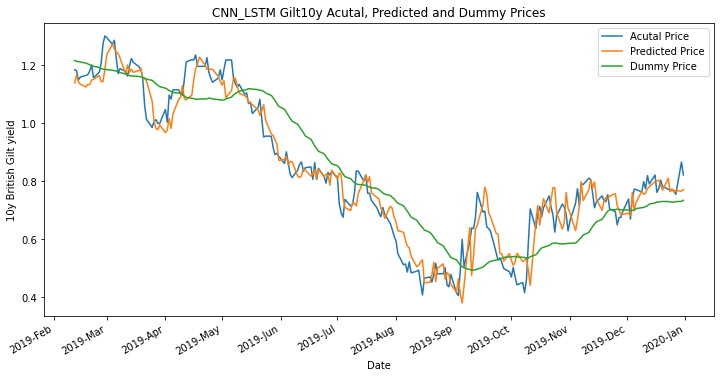

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

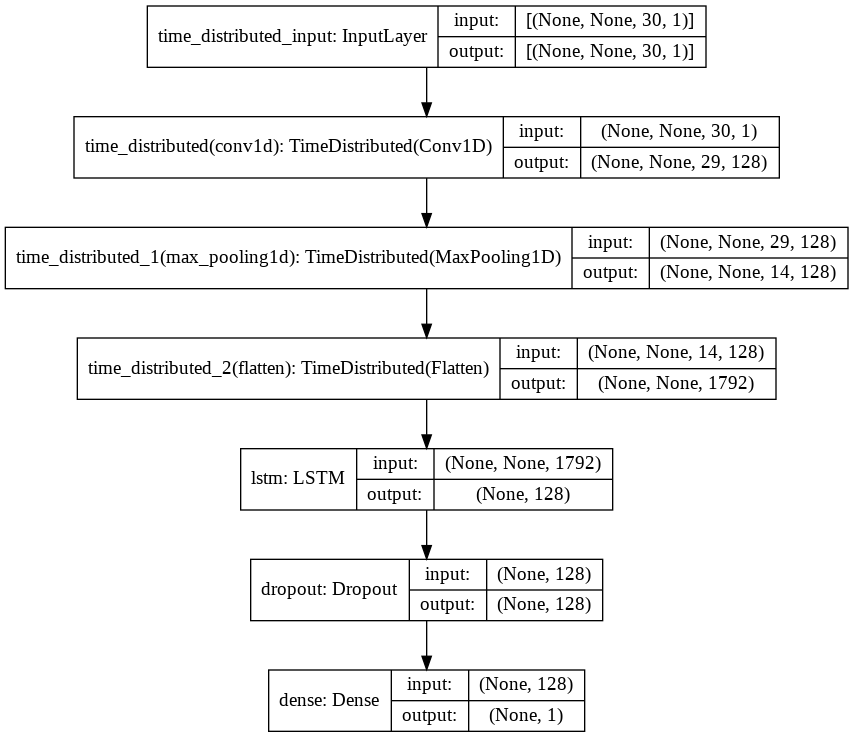

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.00554868206534412
RMSE:  0.07448947620532796
MAE:  0.058481685508528745
Dummy MSE:  0.013891737694778073
Dummy RMSE:  0.11786321603782103
Dummy MAE:  0.09977998323101281


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_LSTM_Gilt10y/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_LSTM_Gilt10y/assets
